In [7]:
! pip install tensorflow tensorflow-datasets mediapipe

In [33]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.core import base_options as mp_base_options
from mediapipe import Image as MPImage
from mediapipe import ImageFormat as MPImageFormat

import cv2
import os
import requests

In [10]:
# Load dataset with splits
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True
)
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
print('Train:', ds_info.splits['train'].num_examples * 0.8)
print('Val:', ds_info.splits['train'].num_examples * 0.2)
print('Test:', ds_info.splits['test'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.TGVIBJ_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.TGVIBJ_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Train: 2016.0
Val: 504.0
Test: 372


In [15]:
MODEL_URL = "https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task"

# Download to memory
resp = requests.get(MODEL_URL, timeout=30)
resp.raise_for_status()
model_bytes = resp.content

# Create the landmarker from bytes (no file path needed)
base_options = mp_base_options.BaseOptions(model_asset_buffer=model_bytes)
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE,
)
hand_landmarker = vision.HandLandmarker.create_from_options(options)
print("Hand landmarker loaded from in-memory bytes")

Hand landmarker loaded from in-memory bytes


In [37]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def extract_landmarks(image, label):
    # Convert tensor to numpy and ensure uint8
    img_np = image.numpy().astype(np.uint8)

    # Create MediaPipe Image
    mp_image = MPImage(image_format=MPImageFormat.SRGB, data=img_np)

    # Detect hand landmarks
    detection_result = hand_landmarker.detect(mp_image)

    # Extract landmarks (21 landmarks * 2 coordinates = 42 features)
    if detection_result.hand_landmarks and len(detection_result.hand_landmarks[0]) == 21:
        landmarks = detection_result.hand_landmarks[0]
        features = np.array([[lm.x, lm.y] for lm in landmarks], dtype=np.float32)
    else:
        # If no hand detected, return None to let us skip later
        features = None

    return features, label

# Process datasets
X_val, y_val = [], []
for i, (image, label) in enumerate(val_ds):
    if i%10==0:
        print(f'val : {i}/{len(val_ds)}')
    features, lbl = extract_landmarks(image, label)
    if features is None:
        continue  # skip samples with no detected hand
    X_val.append(features)
    y_val.append(tf.one_hot(lbl, depth=num_classes).numpy())
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

X_test, y_test = [], []
for i, (image, label) in enumerate(test_ds):
    if i%10==0:
        print(f'Test : {i}/{len(test_ds)}')
    features, lbl = extract_landmarks(image, label)
    if features is None:
        continue
    X_test.append(features)
    y_test.append(tf.one_hot(lbl, depth=num_classes).numpy())
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

X_train, y_train = [], []
for i, (image, label) in enumerate(train_ds):
    if i%10==0:
        print(f'train : {i}/{len(train_ds)}')
    features, lbl = extract_landmarks(image, label)
    if features is None:
        continue
    X_train.append(features)
    y_train.append(tf.one_hot(lbl, depth=num_classes).numpy())
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

val : 0/504
val : 10/504
val : 20/504
val : 30/504
val : 40/504
val : 50/504
val : 60/504
val : 70/504
val : 80/504
val : 90/504
val : 100/504
val : 110/504
val : 120/504
val : 130/504
val : 140/504
val : 150/504
val : 160/504
val : 170/504
val : 180/504
val : 190/504
val : 200/504
val : 210/504
val : 220/504
val : 230/504
val : 240/504
val : 250/504
val : 260/504
val : 270/504
val : 280/504
val : 290/504
val : 300/504
val : 310/504
val : 320/504
val : 330/504
val : 340/504
val : 350/504
val : 360/504
val : 370/504
val : 380/504
val : 390/504
val : 400/504
val : 410/504
val : 420/504
val : 430/504
val : 440/504
val : 450/504
val : 460/504
val : 470/504
val : 480/504
val : 490/504
val : 500/504
Test : 0/372
Test : 10/372
Test : 20/372
Test : 30/372
Test : 40/372
Test : 50/372
Test : 60/372
Test : 70/372
Test : 80/372
Test : 90/372
Test : 100/372
Test : 110/372
Test : 120/372
Test : 130/372
Test : 140/372
Test : 150/372
Test : 160/372
Test : 170/372
Test : 180/372
Test : 190/372
Test : 2

In [38]:
def preprocess_norm(landmarks):
    landmarks = np.array(landmarks, dtype=np.float32)

    # Rebase on wrist
    p0 = landmarks[0]
    landmarks = landmarks - p0

    # determine hand x axis
    vx, vy = (landmarks[17][0] - landmarks[5][0], landmarks[17][1] - landmarks[5][1])
    # guard degenerate axis
    eps = 1e-6
    if np.isfinite(vx) and np.isfinite(vy) and (abs(vx) > eps or abs(vy) > eps):
        theta = -np.arctan2(vy, vx)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s],[s,  c]], dtype=np.float32)
        landmarks = landmarks @ R.T

    # ensure palm faces upwards
    fingertip_indices = [8, 12, 16, 20]
    mean_y = np.mean(landmarks[fingertip_indices, 1])
    if np.isfinite(mean_y) and mean_y < 0:
        landmarks[:, 1] *= -1

    # normalize lengths (avoid divide by zero)
    scale = np.linalg.norm(landmarks[17] - landmarks[5]) + eps
    landmarks = landmarks / scale

    # sanitize
    landmarks = np.nan_to_num(landmarks, nan=0.0, posinf=0.0, neginf=0.0)

    return landmarks.reshape(-1).astype(np.float32)

In [39]:
# Apply preprocessing to all datasets
X_train_norm = np.array([preprocess_norm(landmarks) for landmarks in X_train])
X_val_norm = np.array([preprocess_norm(landmarks) for landmarks in X_val])
X_test_norm = np.array([preprocess_norm(landmarks) for landmarks in X_test])

X_train_norm = np.nan_to_num(X_train_norm, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
X_val_norm   = np.nan_to_num(X_val_norm,   nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
X_test_norm  = np.nan_to_num(X_test_norm,  nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_val_norm shape: {X_val_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")

X_train_norm shape: (1918, 42)
X_val_norm shape: (489, 42)
X_test_norm shape: (369, 42)


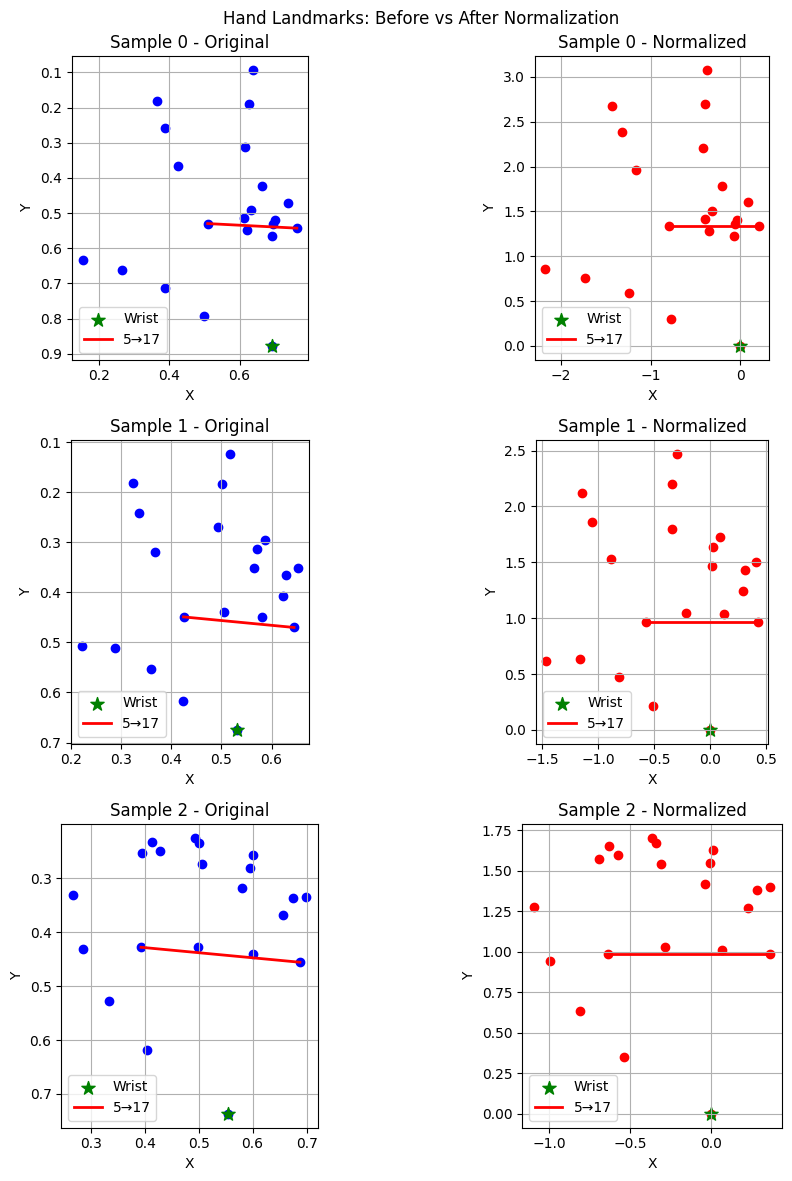

In [40]:
# Visualize before/after for a few samples
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('Hand Landmarks: Before vs After Normalization')

for i in range(3):
    # Before normalization
    landmarks_before = X_train[i].reshape(21, 2)
    axes[i, 0].scatter(landmarks_before[:, 0], landmarks_before[:, 1], c='blue')
    # Highlight wrist (landmark 0)
    axes[i, 0].scatter(landmarks_before[0, 0], landmarks_before[0, 1], c='green', s=100, marker='*', label='Wrist')
    # Draw line from landmark 5 to landmark 17
    axes[i, 0].plot([landmarks_before[5, 0], landmarks_before[17, 0]], 
                    [landmarks_before[5, 1], landmarks_before[17, 1]], 'r-', linewidth=2, label='5→17')
    axes[i, 0].set_title(f'Sample {i} - Original')
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_aspect('equal')
    axes[i, 0].grid(True)
    axes[i, 0].legend()
    
    # After normalization
    landmarks_after = X_train_norm[i].reshape(21, 2)
    axes[i, 1].scatter(landmarks_after[:, 0], landmarks_after[:, 1], c='red')
    # Highlight wrist (landmark 0)
    axes[i, 1].scatter(landmarks_after[0, 0], landmarks_after[0, 1], c='green', s=100, marker='*', label='Wrist')
    # Draw line from landmark 5 to landmark 17
    axes[i, 1].plot([landmarks_after[5, 0], landmarks_after[17, 0]], 
                    [landmarks_after[5, 1], landmarks_after[17, 1]], 'r-', linewidth=2, label='5→17')
    axes[i, 1].set_title(f'Sample {i} - Normalized')
    axes[i, 1].set_xlabel('X')
    axes[i, 1].set_ylabel('Y')
    # axes[i, 1].invert_yaxis()
    axes[i, 1].set_aspect('equal')
    axes[i, 1].grid(True)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [41]:
# Define, train and evaluate a simple MLP classifier on the preprocessed landmark vectors
input_dim = X_train_norm.shape[1]  # should be 42
print("Input dim:", input_dim, "Num classes:", num_classes)


model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

Input dim: 42 Num classes: 3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,147 (211.51 KB)

 Trainable params: 53,251 (208.01 KB)

 Non-trainable params: 896 (3.50 KB)

In [42]:
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=100,
    batch_size=32,
    callbacks=cb,
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Epoch 1/100
60/60 - 4s - 69ms/step - accuracy: 0.9463 - loss: 0.1631 - val_accuracy: 0.9632 - val_loss: 0.5837 - learning_rate: 1.0000e-03
Epoch 2/100
60/60 - 0s - 6ms/step - accuracy: 0.9943 - loss: 0.0282 - val_accuracy: 0.9100 - val_loss: 0.4565 - learning_rate: 1.0000e-03
Epoch 3/100
60/60 - 0s - 6ms/step - accuracy: 0.9958 - loss: 0.0194 - val_accuracy: 0.9898 - val_loss: 0.2283 - learning_rate: 1.0000e-03
Epoch 4/100
60/60 - 0s - 6ms/step - accuracy: 0.9969 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0494 - learning_rate: 1.0000e-03
Epoch 5/100
60/60 - 0s - 6ms/step - accuracy: 0.9974 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0262 - learning_rate: 1.0000e-03
Epoch 6/100
60/60 - 0s - 6ms/step - accuracy: 0.9984 - loss: 0.0108 - val_accuracy: 0.9796 - val_loss: 0.0904 - learning_rate: 1.0000e-03
Epoch 7/100
60/60 - 0s - 6ms/step - accuracy: 0.9984 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0052 - learning_rate: 1.0000e-03
Epoch 8/100
60/60 - 0s - 6ms/step

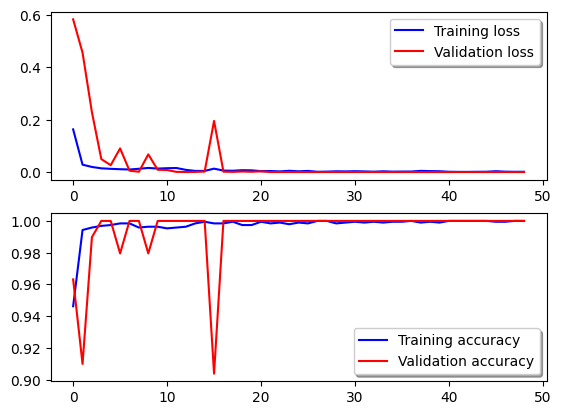

In [44]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
if 'val_loss' in history.history:
    ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history.get('accuracy', []), color='b', label="Training accuracy")
if 'val_accuracy' in history.history:
    ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

        rock       1.00      1.00      1.00       121
       paper       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       369
   macro avg       1.00      1.00      1.00       369
weighted avg       1.00      1.00      1.00       369



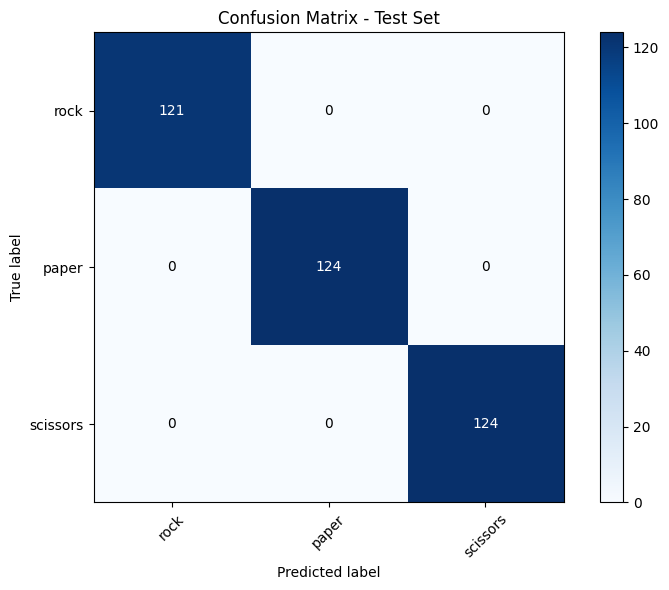

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# Validate model on the test set
y_pred = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
# Save the model in Keras 3 format
model.save('hand_gesture_model.keras')
print("Model saved as 'hand_gesture_model.keras'")